In [102]:
import sys
sys.path.append('../src')
import pwa_cluster as pwac

sys.path.append('../src/fnc')
import UtilityFunc as util #BuildMatEqConstimport DefSystem, DefineRegions, PlotRegions, CurrentRegion, SysEvolution, \
    #BuildMatIneqConst, GetPred, BuildMatCost, BuildMatEqConst
    
from functools import partial

import numpy as np
from scipy import linalg
from scipy import optimize
import matplotlib.pyplot as plt

#from polyhedron import Vrep, Hrep
import polytope

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# Initialization
Time = 25                            # Number of simulation's time steps for first feasible trajectory
n = 2                                # State Dimensions
d = 1                                # Input Dimensions


# model mismatch parameters
A_ERROR = 0.1
B_ERROR = 0.0
N_ITER =  11

# randomness
SEED = 48480085

region_colors = ['salmon', 'grey', 'lightskyblue']
point_colors = ['red', 'black', 'blue']

In [167]:
# Define System Dynamics and Cost Function
[A_true, B_true, Q, R, Q_LMPC, R_LMPC, Vertex, Box_Points, _] = util.DefSystem(np)

total_region = polytope.box2poly([[-2,2],[-1,4]])
F_total = total_region.A
b_total = total_region.b

np.random.seed(SEED)
A = []; B = []
for a in A_true:
    mask = (a != 0)
    A.append(a + A_ERROR * (np.random.uniform(size=a.shape)-1) * mask)
for b in B_true: 
    mask = (b != 0)
    B.append(b + B_ERROR * (np.random.uniform(size=b.shape)-1) * mask)

errors_A = []
errors_B = []

thetas = np.zeros( np.hstack([3, n+d+1, n]))
centroids = np.array([[1,0], [-0.75,0], [0.5,2.5]])
# thetas_true = []
# for a,b in zip(A_true,B_true):
#     thetas_true.append(np.vstack([a.T,b.T,np.zeros([1,a.shape[1]])]))
# thetas_true = np.array(thetas_true)
# theta_estimation = []

Vertex = []
F_region = []; b_region = [];
for box in Box_Points:
    p = polytope.box2poly(box) #Polytope(vertices=Vertex)
    Vertex.append(polytope.extreme(p))
    F_region.append(p.A); b_region.append(p.b)


/home/sarah/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sarah/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 0.798305993125 0.592503772257
1 0.229128712322 0.0385314853767
2 0.211880611406 0.0322211959114
3 0.230522908161 0.0434154968517
4 0.242698050341 0.0381747374866
5 0.221978316315 0.0163313789965
6 0.213440513849 0.0159685046134
7 0.208135727932 0.0157739857271
8 0.208260993445 0.0174359424267
9 0.19911271221 0.0247744193064
10 0.200638684997 0.024376530364


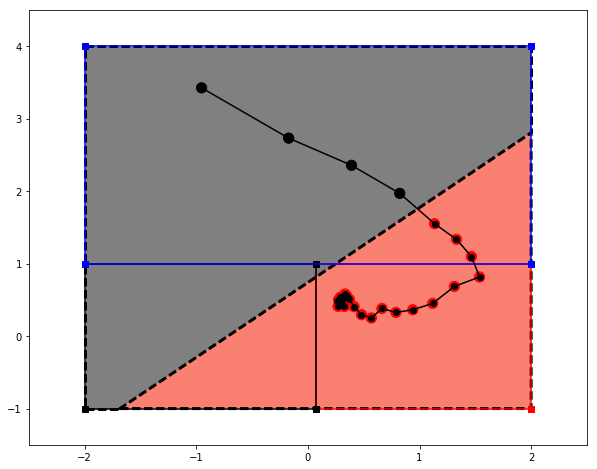

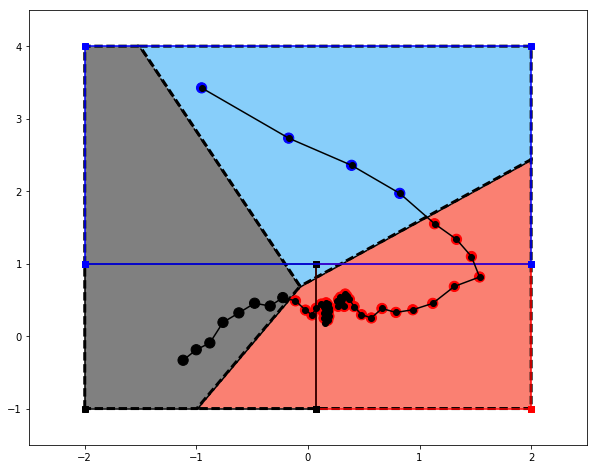

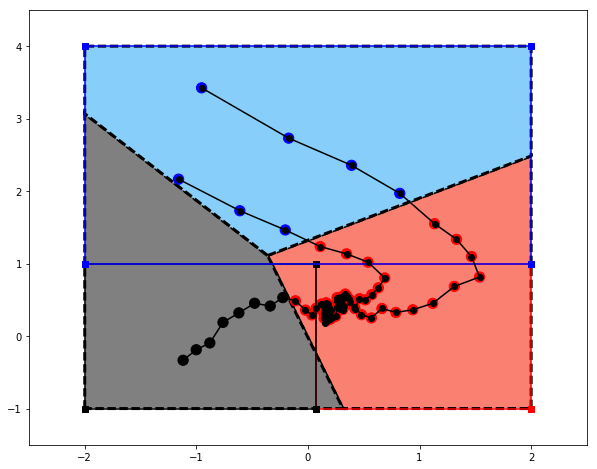

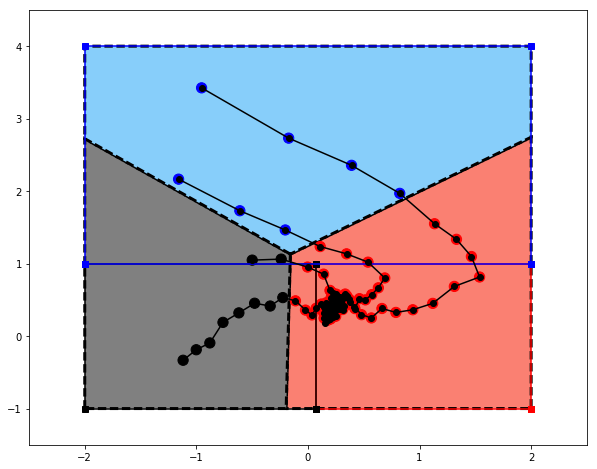

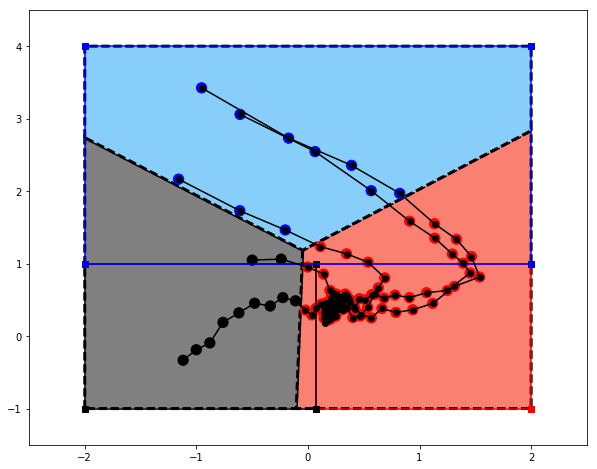

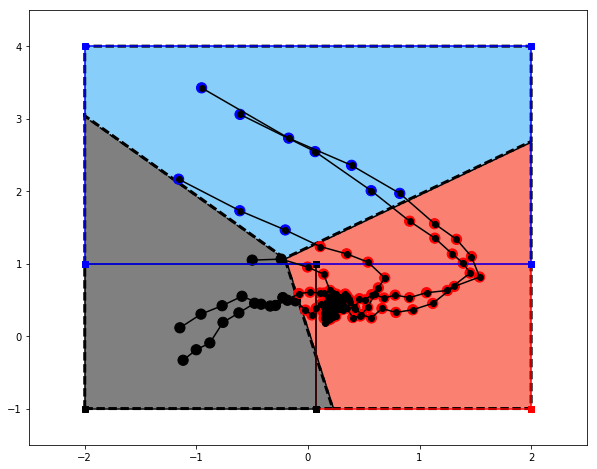

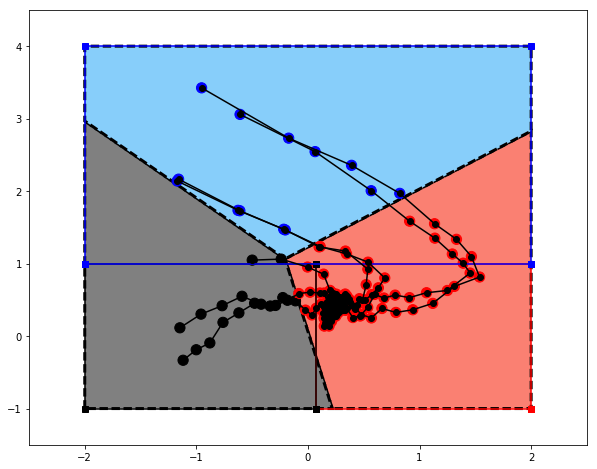

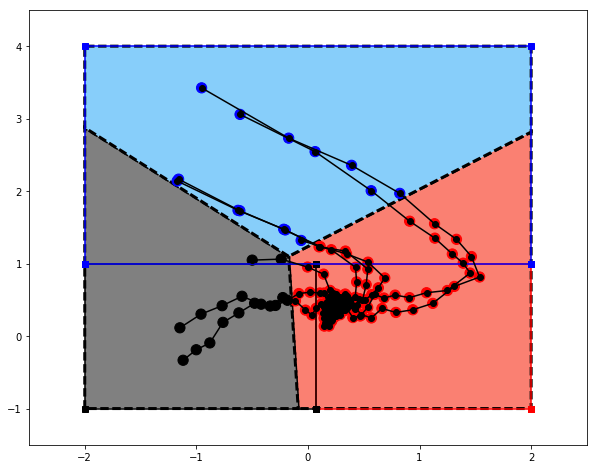

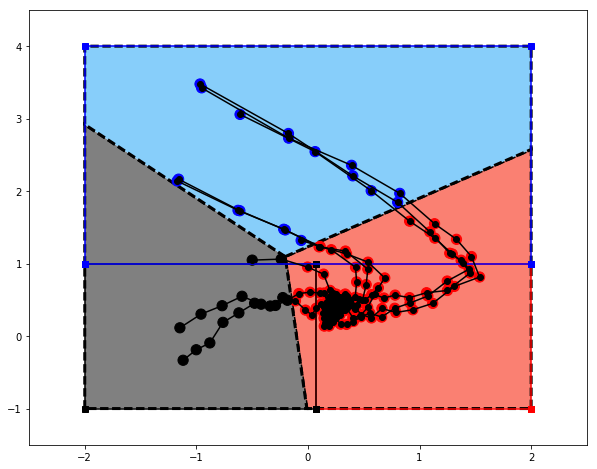

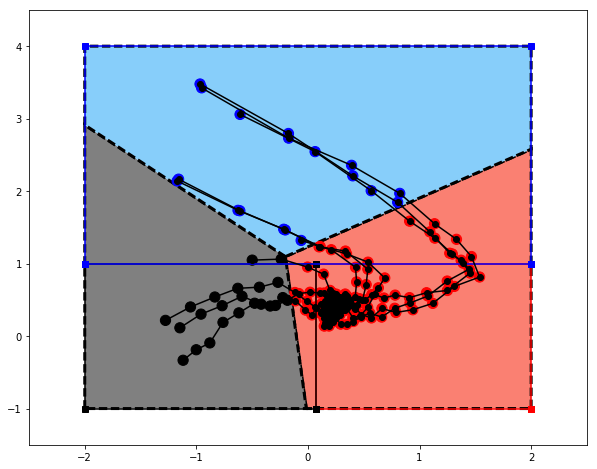

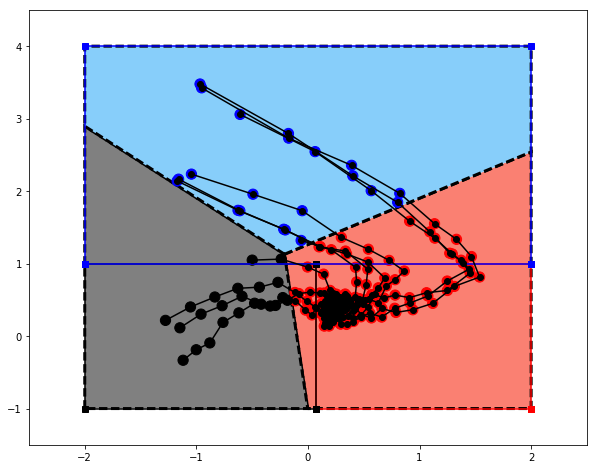

In [173]:
# Use data to fit linear models
zs = []; ys = []; cluster_labels = [];


x = np.zeros([n,Time+1,N_ITER])    # Initialize the closed loop trajectory
u = np.zeros([d,Time,N_ITER])      # Initialize the closed loop input

image_ind = 0
for j in range(N_ITER):
    # Set initial Conditions in Regions
    if j % 4 == 0:
        x[:,0,j] = np.array([-1, 2.5]) + 0.5 * np.random.uniform(size=[2]) * np.array([1,2])
    elif j % 4 == 1:
        x[:,0,j] = np.array([-1.5, -0.5]) + 0.5 * np.random.uniform(size=[2]) * np.array([1,2])
    elif j % 4 == 2:
        x[:,0,j] = np.array([-1.5, 2]) + 0.5 * np.random.uniform(size=[2]) * np.array([1,2])
    else:
        x[:,0,j] = np.array([-0.5, 0.5]) + 0.5 * np.random.uniform(size=[2]) * np.array([1,2])
        
    K = np.array([0.4221,  1.2439])
    K = K + 0 * np.random.uniform(size=K.shape) # Pick feedback gain for the first feasible trajectory
    
    # Time loop: apply the above feedback gain
    for i in range(0, Time):
        u[:,i,j] = -0.1*np.dot(K, x[:,i,j]) + 0.25 * np.random.uniform()
        x[:,i+1,j] = util.SysEvolution(x[:,i,j], u[:,i,j], F_region, b_region, np, util.CurrentRegion, A_true, B_true)

    if A_ERROR > 0 or B_ERROR > 0:
        # update datapoints
        for i in range(0, Time):
            cluster_labels.append(util.CurrentRegion(x[:,i,j], F_region, b_region, np, 0))
            zs.append(np.hstack([x[:,i,j], u[:,i,j]]))
            ys.append(x[:,i+1,j]) 

        pwa_model = pwac.ClusterPWA(np.array(zs), np.array(ys), [centroids, thetas], z_cutoff = n)

        pwa_model.fit_clusters()
        
        
        
        
        pwa_model.determine_polytopic_regions()
        if j > 2:
            centroids = pwa_model.centroids
            thetas = pwa_model.thetas
        
        A_est = []; B_est = [];
        A_err = []; B_err = []
        for theta in pwa_model.thetas:
            A_est.append(theta[0:n,:].T)
            A_err.append(np.linalg.norm(A_est[-1]-A_true))
            B_est.append(theta[n:n+d,:].T)
            B_err.append(np.linalg.norm(B_est[-1]-B_true))
        A = A_est
        B = B_est
        errors_A.append(A_err)
        errors_B.append(B_err)
        print(j, np.mean(A_err), np.mean(B_err))
        
        Fs, bs = pwac.getRegionMatrices(pwa_model.region_fns)

        plt.figure(figsize=(10,8)); 
        ax = plt.subplot(1,1,1)
        ax.plot(np.hstack(((Vertex_plot[0])[:, 0], np.squeeze(Vertex_plot[0])[0, 0])),
                 np.hstack(((Vertex_plot[0])[:, 1], np.squeeze(Vertex_plot[0])[0, 1])), "-rs")
        ax.plot(np.hstack(((Vertex_plot[1])[:, 0], np.squeeze(Vertex_plot[1])[0, 0])),
                 np.hstack(((Vertex_plot[1])[:, 1], np.squeeze(Vertex_plot[1])[0, 1])), "-ks")
        ax.plot(np.hstack(((Vertex_plot[2])[:, 0], np.squeeze(Vertex_plot[2])[0, 0])),
                 np.hstack(((Vertex_plot[2])[:, 1], np.squeeze(Vertex_plot[2])[0, 1])), "-bs")
        
        for k in range(j+1):
            ax.plot(x[0, 0:Time + 1, k], x[1, 0:Time + 1, k], '-o', c='black')
            
        ax.set_xlim([-2.5,2.5])
        ax.set_ylim([-1.5, 4.5])
        plt.savefig("images/pwa_sysid" + str(image_ind) + ".png")
        image_ind = image_ind + 1
        
        colorlist =  []
        for label in pwa_model.cluster_labels:
            colorlist.append(point_colors[int(label)])
        ax.scatter(np.array(zs)[:,0], np.array(zs)[:,1], c=colorlist,s=105)
        
        ax.set_xlim([-2.5,2.5])
        ax.set_ylim([-1.5, 4.5])
        plt.savefig("images/pwa_sysid" + str(image_ind) + ".png")
        image_ind = image_ind + 1

        for k,R in enumerate(zip(Fs,bs)):
            F = R[0]; b = R[1]
            F_intersect = np.vstack([F,F_total])
            b_intersect = np.hstack([b,b_total])
            p = polytope.Polytope(A=F_intersect, b=b_intersect)
            p.plot(ax, color=region_colors[k], alpha=1)
        
        ax.set_xlim([-2.5,2.5])
        ax.set_ylim([-1.5, 4.5])
        plt.savefig("images/pwa_sysid" + str(image_ind) + ".png")
        image_ind = image_ind + 1


In [107]:
! convert -delay 50 -loop 1 images/pwa_sysid{0..10}.png images/pwa_sysid_animate.gif

convert: unable to open image `images/pwa_sysid{0..10}.png': No such file or directory @ error/blob.c/OpenBlob/2712.
convert: unable to open file `images/pwa_sysid{0..10}.png' @ error/png.c/ReadPNGImage/3919.
convert: no images defined `images/pwa_sysid_animate.gif' @ error/convert.c/ConvertImageCommand/3210.


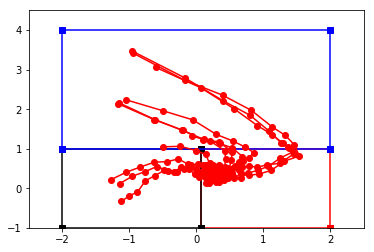

ValueError: x and y must have same first dimension, but have shapes (11,) and (45,)

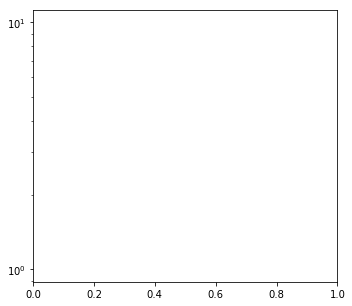

In [174]:
for Vertex_plot in [Vertex]:
    plt.plot(np.hstack(((Vertex_plot[0])[:, 0], np.squeeze(Vertex_plot[0])[0, 0])),
                 np.hstack(((Vertex_plot[0])[:, 1], np.squeeze(Vertex_plot[0])[0, 1])), "-rs")
    plt.plot(np.hstack(((Vertex_plot[1])[:, 0], np.squeeze(Vertex_plot[1])[0, 0])),
             np.hstack(((Vertex_plot[1])[:, 1], np.squeeze(Vertex_plot[1])[0, 1])), "-ks")
    plt.plot(np.hstack(((Vertex_plot[2])[:, 0], np.squeeze(Vertex_plot[2])[0, 0])),
             np.hstack(((Vertex_plot[2])[:, 1], np.squeeze(Vertex_plot[2])[0, 1])), "-bs")

plt.plot(x[0,0:Time+1,0], x[1,0:Time+1,0], '-ro')
for i in range(1,N_ITER):
    plt.plot(x[0, 0:Time + 1, i], x[1, 0:Time + 1, i], '-ro')

plt.xlim([-2.5, 2.5])
plt.ylim([-1, 4.5])
plt.show()

errors_A = np.array(errors_A)
errors_B = np.array(errors_B)

if A_ERROR > 0 or B_ERROR > 0:
    plt.figure(figsize=(12,5));
    for i in range(errors_A.shape[1]):
        plt.subplot(1,2,1)
        plt.semilogy(25*np.linspace(1,11,11), errors_A[:,i], c=region_colors[i]); plt.title("A estimation error")
        plt.xlabel('datapoints'); plt.ylabel('estimation error')
        plt.subplot(1,2,2)
        plt.semilogy(25*np.linspace(1,11,11), errors_B[:,i], c=region_colors[i]); plt.title("B estimation error")
        plt.xlabel('datapoints'); plt.ylabel('estimation error')
plt.savefig("images/pwa_sysid_estimate_errors.png")

In [49]:
errors_A = np.array(errors_A)
errors_B = np.array(errors_B)


In [163]:
zs

[array([-0.69925,  3.22734, -0.37172]),
 array([ 0.01615,  2.53289, -0.28205]),
 array([ 0.52111,  1.99755, -0.26287]),
 array([ 0.86851,  1.53493, -0.18176]),
 array([ 1.08864,  1.19968, -0.07729]),
 array([ 1.21971,  1.00242, -0.09742]),
 array([ 1.29823,  0.80476, -0.02124]),
 array([ 1.11906,  0.62257,  0.12055]),
 array([ 0.9575 ,  0.6186 ,  0.01159]),
 array([ 0.82786,  0.50647, -0.06824]),
 array([ 0.71294,  0.33693,  0.13741]),
 array([ 0.60404,  0.40695, -0.00915]),
 array([ 0.52393,  0.31641,  0.15391]),
 array([ 0.45078,  0.40704,  0.16336]),
 array([ 0.40133,  0.489  ,  0.09027]),
 array([ 0.36996,  0.48147,  0.06636]),
 array([ 0.34412,  0.45154,  0.09803]),
 array([ 0.32045,  0.45926,  0.01347]),
 array([ 0.30229,  0.38088,  0.00528]),
 array([ 0.27992,  0.30999,  0.15875]),
 array([ 0.25493,  0.40674, -0.02346]),
 array([ 0.24462,  0.30193,  0.18225]),
 array([ 0.22589,  0.42379,  0.17177]),
 array([ 0.22309,  0.5108 ,  0.15269]),
 array([ 0.22955,  0.56133,  0.0607 ]),


In [96]:
np.linspace(1,11,11)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.])

(-1.6194843600403197,
 1.4690828729914525,
 -0.12335274032665308,
 3.4013555956336772)

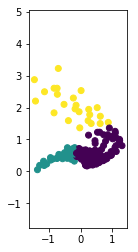

In [165]:
plt.subplot(1,3,3); plt.scatter(np.array(zs)[:,0], np.array(zs)[:,1], c=pwa_model.cluster_labels); plt.axis('equal')
